In [ ]:
from __future__ import annotations

import pathlib

import cv2
import numpy as np
import PIL
import PIL.Image
import rpg_e2vid.utils.inference_utils as inference_utils
import rpg_e2vid.utils.loading_utils as loading_utils
import torch
import tqdm

import const
import utils

In [ ]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [ ]:
vid = "street2"

src_frames = utils.read_video(const.VIDEOS_DIR / f"{vid}.mp4")
src_frames.array = utils.crop_vid_to_size(src_frames.array, 640, 480)

Reading c:\Extra\Masters\event-sun-effects-remover\data-prep\videos\street2.mp4: 100%|██████████| 575/575 [00:02<00:00, 284.48it/s]


In [ ]:
outpath = pathlib.Path("./videos/pres")

In [ ]:
align_meta = utils.AlignMeta.from_json(const.META_DIR / f"match-{vid}.json")
ts_offset_ms = align_meta.offset_ms

In [ ]:
events = utils.EventsData.from_path(f"./parsed/{vid}.bin")
_, ts_counts = np.unique(events.array[:, 0], return_counts=True)

### Video RGB + Individual Event Frames

In [ ]:
skip_events = ts_counts[:ts_offset_ms].sum()
events_arr_trimmed = events.array[skip_events:]
ts_counts_trimmed = ts_counts[ts_offset_ms:]

In [ ]:
start_frame = 20
show_frames = 20

In [ ]:
eit = utils.EventWindowIterator(
    events_arr_trimmed,
    ts_counts_trimmed,
    window_length=1,
    offset=src_frames.timestamps[start_frame],
)
combined_vid = []
for ts, window in zip(
    range(
        src_frames.timestamps[start_frame],
        src_frames.timestamps[start_frame + show_frames],
    ),
    eit,
):
    window = window.astype(int)
    frame_idx = src_frames.timestamps.searchsorted(ts)
    frame = src_frames.array[frame_idx]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    event_frame = np.ones_like(frame) * 255
    event_frame[window[:, 2], window[:, 1], :] = 0
    event_frame[window[:, 2], window[:, 1], 2] = window[:, 3] * 255
    event_frame[window[:, 2], window[:, 1], 0] = (~window[:, 3] + 2) * 255
    combined_frame = np.hstack([event_frame, frame])
    cv2.putText(
        combined_frame,
        f"Time: {ts-src_frames.timestamps[start_frame]:>3}ms",
        (20, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 0, 0),
        3,
    )
    combined_vid.append(combined_frame)
combined_vid = np.array(combined_vid, dtype=np.uint8)

In [ ]:
out = cv2.VideoWriter(
    outpath / f"{vid}_combined.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    60,
    (combined_vid.shape[2], combined_vid.shape[1]),
)

for frame in tqdm.tqdm(combined_vid):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(frame)
out.release()

100%|██████████| 671/671 [00:02<00:00, 305.96it/s]


### Reconstructed Video Raw

In [ ]:
MODEL_PATH = pathlib.Path("../pretrained/E2VID_lightweight.pth.tar")
model = loading_utils.load_model(MODEL_PATH).to(const.DEVICE)

c:\Users\njytwf\AppData\Local\anaconda3\envs\masters\lib\site-packages\rpg_e2vid\utils\loading_utils.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_model = torch.lo

Using TransposedConvLayer (fast, with checkerboard artefacts)


In [ ]:
eit = utils.EventWindowIterator(
    events.array.copy(),
    ts_counts,
    window_length=50,
    offset=src_frames.timestamps[start_frame],
    stride=50,
)
rec_frames = []
prev = None
for window in tqdm.tqdm(eit):
    vg = inference_utils.events_to_voxel_grid(window, 5, events.width, events.height)
    vg = torch.from_numpy(vg).unsqueeze(0).float().to(const.DEVICE)
    with torch.no_grad():
        pred, prev = model(vg, prev)
        pred = (pred.squeeze().cpu().numpy() * 255).astype(np.uint8)
    rec_frames.append(pred)
rec_frames = np.array(rec_frames)

 96%|█████████▋| 387/402 [00:38<00:01, 10.09it/s]


In [ ]:
# Save reconstructed video
out = cv2.VideoWriter(
    outpath / f"{vid}_reconstructed.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    30,
    (rec_frames.shape[2], rec_frames.shape[1]),
    isColor=False,
)

for frame in tqdm.tqdm(rec_frames):
    out.write(frame)
out.release()

100%|██████████| 387/387 [00:00<00:00, 665.47it/s]


### Temporal Alignment

In [ ]:
def overlay_events_on_video(
    src_frames: utils.Frames,
    events: np.ndarray,
    ts_counts: np.ndarray,
    alignment: utils.AlignMeta,
    model: torch.nn.Module,
    align_space: bool = False,
) -> tuple[np.ndarray, np.ndarray]:
    count_index = 0
    event_index = 0
    overlayed = src_frames.array.copy()
    prev = None
    masks = utils.make_horiz_masks(
        len(alignment.homographies), src_frames.width, src_frames.height
    )
    hom_mask = alignment.get_common_mask(src_frames.width, src_frames.height) > 0
    for i in tqdm.tqdm(range(1, src_frames.num_frames), desc="Overlaying frames"):
        if src_frames.timestamps[i] == 0:
            continue
        window_start = src_frames.timestamps[i - 1]
        window_end = src_frames.timestamps[i]
        events_in_window = ts_counts[window_start:window_end].sum()
        events_end = event_index + events_in_window
        window = events[event_index:events_end]
        if not len(window):
            break
        count_index += src_frames.timestamps[i]
        event_index = events_end
        voxel_grid = inference_utils.events_to_voxel_grid(
            window, 5, src_frames.width, src_frames.height
        )
        voxel_grid = torch.from_numpy(voxel_grid).to(const.DEVICE).unsqueeze(0).float()
        with torch.no_grad():
            pred, prev = model(voxel_grid, prev)
            pred = (pred.squeeze().cpu().numpy() * 255).astype(np.uint8)
        pred = cv2.undistort(pred, const.EVENT_MTX, const.EVENT_DIST)
        pred_gb = cv2.GaussianBlur(pred, (0, 0), 3)
        pred = cv2.addWeighted(pred, 1.5, pred_gb, -0.5, 0)
        if align_space:
            full_pred = np.zeros((src_frames.height, src_frames.width), np.uint8)
            for mask, hom in zip(masks, alignment.homographies):
                hom_warped = cv2.warpPerspective(
                    pred.copy(), hom, (src_frames.width, src_frames.height)
                )
                full_pred[mask > 0] = hom_warped[mask > 0]
            pred = full_pred
        pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2BGR)
        overlayed[i, :, : src_frames.width // 2] = pred[:, : src_frames.width // 2]

    return overlayed

In [ ]:
res = overlay_events_on_video(
    src_frames, events_arr_trimmed, ts_counts_trimmed, align_meta, model
)

Overlaying frames:  96%|█████████▋| 553/574 [00:56<00:02,  9.82it/s]


In [ ]:
# Save overlayed video
out = cv2.VideoWriter(
    outpath / f"{vid}_overlayed.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    30,
    (res.shape[2], res.shape[1]),
)

for frame in tqdm.tqdm(res):
    out.write(frame)
out.release()

100%|██████████| 575/575 [00:01<00:00, 538.27it/s]


### Temporal + Spatial alignment

In [ ]:
res = overlay_events_on_video(
    src_frames,
    events_arr_trimmed,
    ts_counts_trimmed,
    align_meta,
    model,
    align_space=True,
)

Overlaying frames:  96%|█████████▋| 553/574 [00:58<00:02,  9.44it/s]


In [ ]:
# Save overlayed video
out = cv2.VideoWriter(
    outpath / f"{vid}_overlayed_aligned.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    30,
    (res.shape[2], res.shape[1]),
)

for frame in tqdm.tqdm(res):
    out.write(frame)
out.release()

100%|██████████| 575/575 [00:01<00:00, 540.13it/s]


### Citiscape samples

In [ ]:
samples = list(pathlib.Path("../data/processed/cityscapes").glob("*.npy"))
np.random.shuffle(samples)

In [ ]:
vis_samples = []
for sample in samples[:5]:
    sample_arr = np.load(sample)
    sample_bgr = sample_arr[:, :, :3]
    sample_event = sample_arr[:, :, 3]
    stacked = np.vstack([sample_bgr, cv2.cvtColor(sample_event, cv2.COLOR_GRAY2BGR)])
    vis_samples.append(stacked)
stacked = np.hstack(vis_samples)
showarray(stacked)

NameError: name 'showarray' is not defined

### Rec Video

In [ ]:
rec_paths = list(pathlib.Path("../data/infer/sun9/").glob("*.npy"))
len(rec_paths)

808

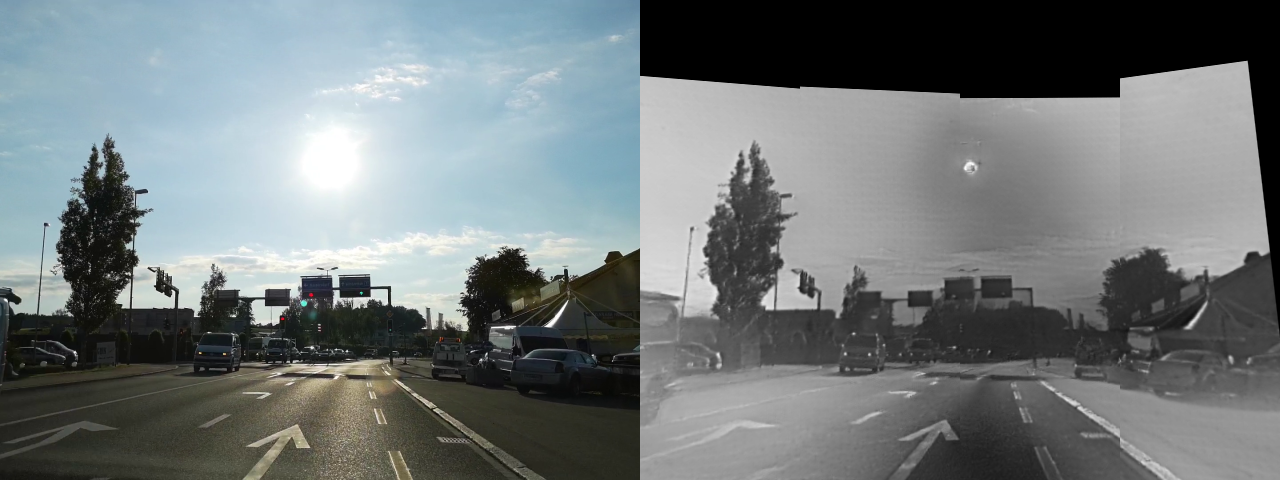

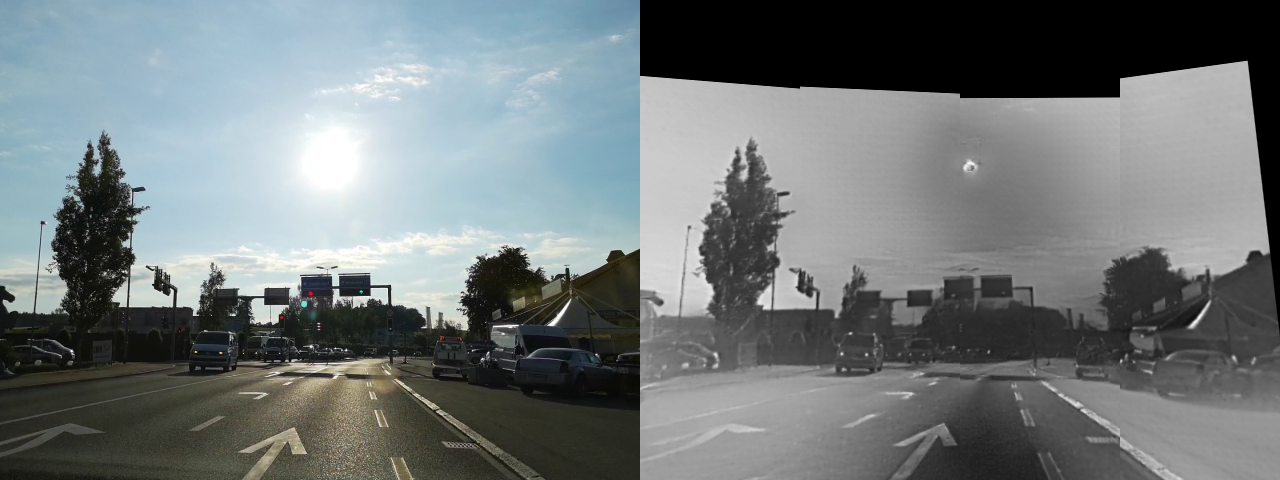

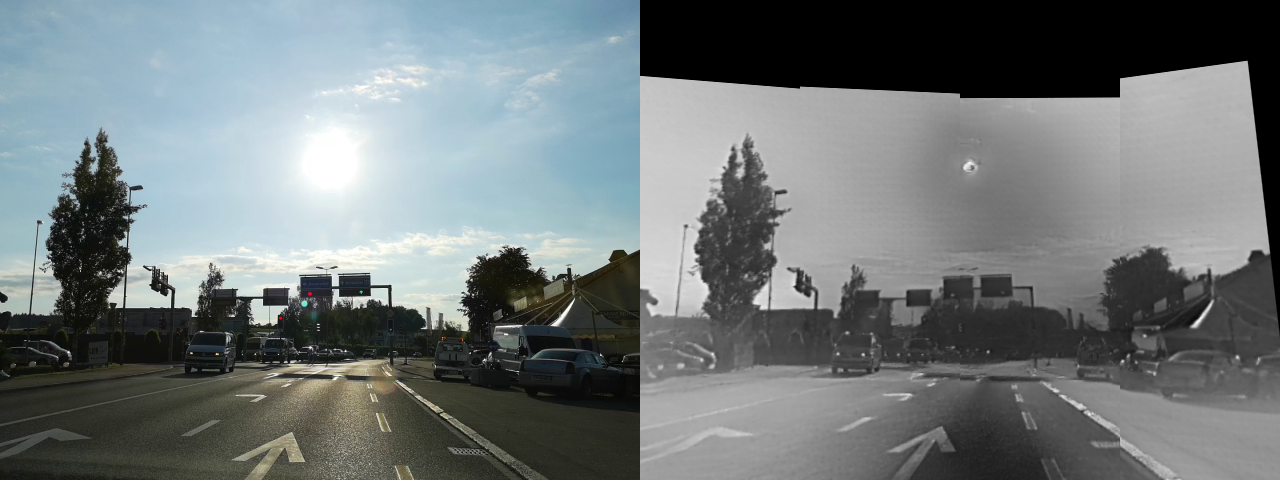

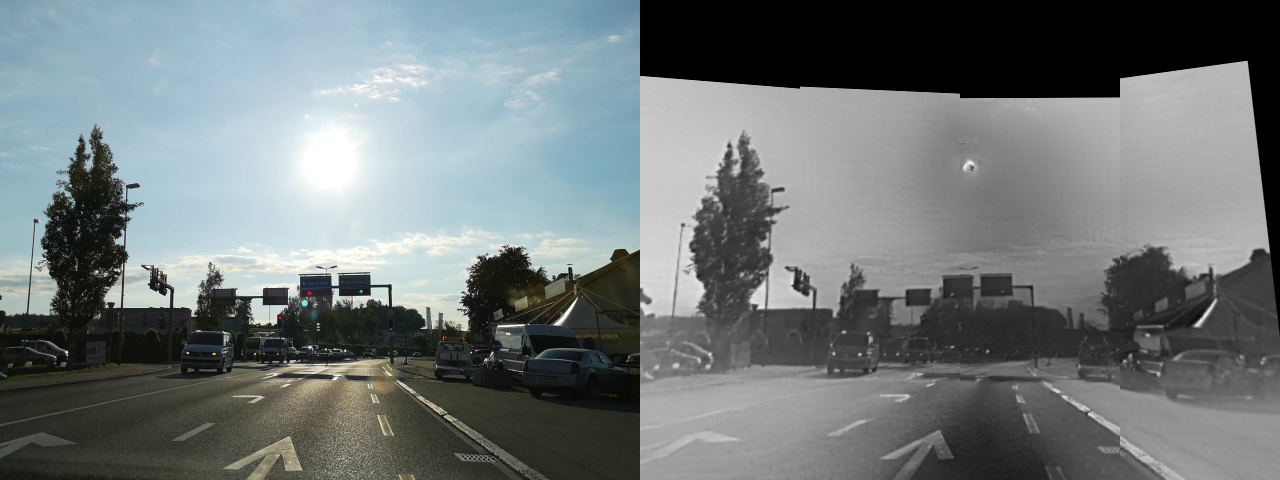

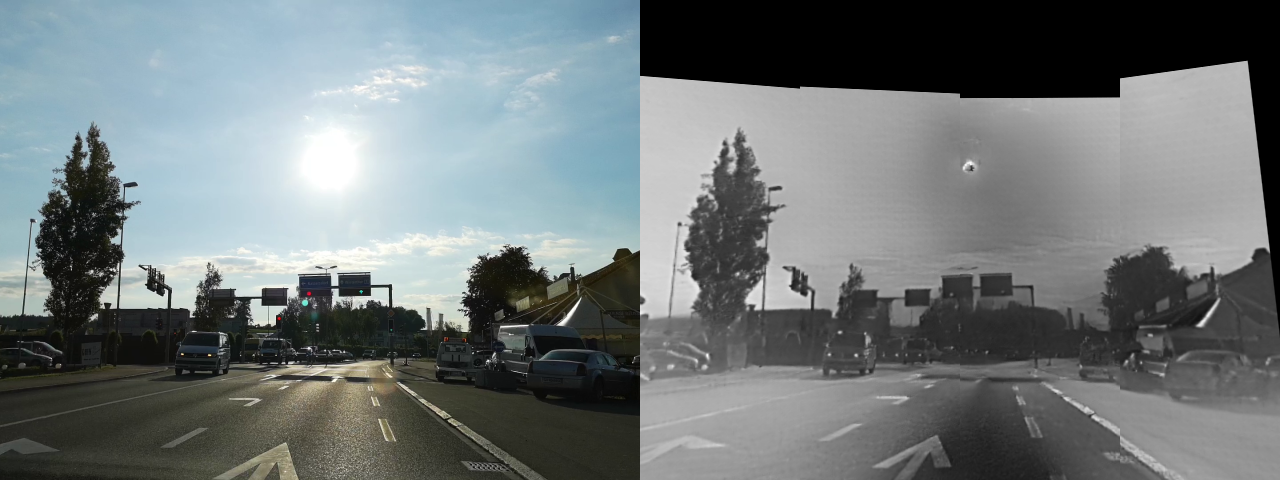

In [ ]:
for rec_path in rec_paths[100:105]:
    rec_arr = np.load(rec_path)
    rec_bgr = rec_arr[:, :, :3]
    rec_event = rec_arr[:, :, 3]
    stacked = np.hstack([rec_bgr, cv2.cvtColor(rec_event, cv2.COLOR_GRAY2BGR)])
    showarray(stacked)

### Sun9 infer orig

In [ ]:
orig_paths = list(pathlib.Path("../data/infer/sun9-sm/").glob("*.npy"))
len(orig_paths)

109

In [28]:
out = cv2.VideoWriter(
    outpath / "sun9-sm.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    30,
    (640, 480),
)
for orig_path in tqdm.tqdm(orig_paths):
    orig_arr = np.load(orig_path)
    orig_bgr = orig_arr[:, :, :3]
    out.write(orig_bgr)
out.release()

100%|██████████| 109/109 [00:00<00:00, 258.32it/s]
